# Pneumonia Detecion with ResNet50

## Dataset

In [3]:
import torch
# data handling
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class ChestXrayDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    


In [3]:
# Organize data paths and labels
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def resolve_data_path(data_dir: str):
    normal_dir = os.path.join(data_dir, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')

    normal_paths = [os.path.join(data_dir, 'NORMAL', f) for f in os.listdir(normal_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    pneumonia_paths = [os.path.join(data_dir, 'PNEUMONIA', f) for f in os.listdir(pneumonia_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    pathes = normal_paths + pneumonia_paths
    labels = [0]*len(normal_paths) + [1]*len(pneumonia_paths)
    return pd.DataFrame({'path': pathes, 'label': labels})

# Base dir
train_df = resolve_data_path("datasets/all_data")
test_df = resolve_data_path("datasets/test")

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# compute class weights
class_counts = train_df['label'].value_counts().to_dict()
total_samples = len(train_df)
class_weights = {cls: total_samples/count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_df['label']]
# ouptput class weights
print("Class Weights:", class_weights)

print(train_df.head(20))

Class Weights: {1: 1.3473921442369607, 0: 3.8785912882298423}
                                                   path  label
3566  datasets/all_data/PNEUMONIA/person1483_bacteri...      1
2866  datasets/all_data/PNEUMONIA/person591_bacteria...      1
2681  datasets/all_data/PNEUMONIA/person361_virus_74...      1
1199  datasets/all_data/NORMAL/NORMAL2-IM-1438-0001....      0
4619  datasets/all_data/PNEUMONIA/person450_bacteria...      1
1008         datasets/all_data/NORMAL/IM-0349-0001.jpeg      0
1295  datasets/all_data/NORMAL/NORMAL2-IM-1261-0001....      0
2688  datasets/all_data/PNEUMONIA/person994_virus_16...      1
3142  datasets/all_data/PNEUMONIA/person1098_bacteri...      1
82    datasets/all_data/NORMAL/NORMAL2-IM-0898-0001....      0
4042  datasets/all_data/PNEUMONIA/person67_bacteria_...      1
5037  datasets/all_data/PNEUMONIA/person886_virus_15...      1
1980  datasets/all_data/PNEUMONIA/person1617_bacteri...      1
4688  datasets/all_data/PNEUMONIA/person333_bacteria... 

In [3]:
# compute the mean and std of images in the training set
import cv2
import tqdm
import numpy as np

def compute_mean_std(df: pd.DataFrame):
    sum_ = 0.0
    sum_squared = 0.0
    num_pixels = 0

    for idx in tqdm.tqdm(range(len(df))[:10]):
        img_path = df.iloc[idx]['path']
        image = cv2.imread(img_path)
        image = image.astype('float32') / 255.0  # Normalize to [0, 1]
        # compute sum and sum of squares for each channel
        sum_ += image.sum(axis=(0, 1))
        sum_squared += (image ** 2).sum(axis=(0, 1))
        num_pixels += image.shape[0] * image.shape[1]

    mean = sum_ / num_pixels
    std = np.sqrt((sum_squared / num_pixels) - (mean ** 2))
    return mean, std
mean, std = compute_mean_std(train_df)
print(f"Mean: {mean}, Std: {std}")

100%|██████████| 10/10 [00:00<00:00, 29.60it/s]

Mean: [0.47240412 0.47240412 0.47240412], Std: [0.25500405 0.25500405 0.25500405]


In [5]:
# Define transforms, dataloaders
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    # Normalize with ImageNet stats, beacause resnet is pretrained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Model Training With Cross Validation

In [9]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def train_epoch(model, dataloader, criterion, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step(loss)
            
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_epoch(model, dataloader, criterion):
    model.eval()
    
    all_preds, all_trues, all_probs = [], [], []
    val_loss = 0.0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item() * inputs.size(0)
            total += labels.size(0)
            # q: why [:, 1]?
            # a: get the probabilities for the positive class
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = (probs >= 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(labels.cpu().numpy())
    val_loss /= total
    return val_loss, all_preds, all_trues, all_probs

def compute_metrics(all_trues, all_preds, all_probs):
    val_recall = recall_score(all_trues, all_preds, pos_label=1)
    val_specificity = recall_score(all_trues, all_preds, pos_label=0)
    val_f1 = f1_score(all_trues, all_preds, average='weighted')
    val_auc = roc_auc_score(all_trues, all_probs)
    return val_recall, val_specificity, val_f1, val_auc

In [ ]:
from itertools import product
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights, ResNet101_Weights, ResNet152_Weights

# hyperparameters
learning_rates = [1e-4, 3e-5]
batch_sizes = [32, 64]
num_epochs = 5

# Results dict, to check performance of different hyperparameter combinations
results = {}

for lr, bs in product(learning_rates, batch_sizes):
    print(f"Training with lr={lr}, batch_size={bs}")
    
    # Create dataloaders
    train_dataset = ChestXrayDataset(train_df, transform=train_transform)
    val_dataset = ChestXrayDataset(val_df, transform=val_test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)
    
    # Model, criterion, optimizer
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)  # binary classification
    model = model.to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        _, all_preds, all_trues, all_probs = eval_epoch(model, val_loader, criterion)
        val_recall, val_specificity, val_f1, val_auc = compute_metrics(all_trues, all_preds, all_probs)
        
        val_acc = (val_recall + val_specificity) / 2
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
        
        results[(lr, bs)] = {'val_recall': val_recall, 'val_specificity': val_specificity, 'val_f1': val_f1, 'val_auc': val_auc}

# Best (by val weighted F1 for balance)
best_params = max(results, key=lambda x: results[x]['val_f1'])
print(f"Best: LR={best_params[0]}, BS={best_params[1]}, Val F1={results[best_params]['val_f1']:.4f}, Recall={results[best_params]['val_recall']:.4f}, Specificity={results[best_params]['val_specificity']:.4f}")
        


Training with lr=0.0001, batch_size=32
Epoch 1/5, Train Loss: 0.1810, Train Acc: 0.9317, Val Acc: 0.9681, Val F1: 0.9743, Val AUC: 0.9941
Epoch 2/5, Train Loss: 0.0809, Train Acc: 0.9737, Val Acc: 0.9629, Val F1: 0.9515, Val AUC: 0.9969
Epoch 3/5, Train Loss: 0.0597, Train Acc: 0.9780, Val Acc: 0.9812, Val F1: 0.9847, Val AUC: 0.9982
Epoch 4/5, Train Loss: 0.0544, Train Acc: 0.9816, Val Acc: 0.9750, Val F1: 0.9809, Val AUC: 0.9983
Epoch 5/5, Train Loss: 0.0381, Train Acc: 0.9857, Val Acc: 0.9684, Val F1: 0.9817, Val AUC: 0.9992
Training with lr=0.0001, batch_size=64
Epoch 1/5, Train Loss: 0.2056, Train Acc: 0.9290, Val Acc: 0.9424, Val F1: 0.9661, Val AUC: 0.9956
Epoch 2/5, Train Loss: 0.0739, Train Acc: 0.9742, Val Acc: 0.9499, Val F1: 0.9719, Val AUC: 0.9981
Epoch 3/5, Train Loss: 0.0564, Train Acc: 0.9795, Val Acc: 0.9407, Val F1: 0.9669, Val AUC: 0.9978
Epoch 4/5, Train Loss: 0.0468, Train Acc: 0.9830, Val Acc: 0.9610, Val F1: 0.9778, Val AUC: 0.9974
Epoch 5/5, Train Loss: 0.0358, 


=== 5-FOLD CV WITH LEARNING CURVES & CONFUSION MATRICES ===


--- Fold 1 ---
Epoch 1/12, Train Loss: 0.1952, Train Acc: 0.9223,               Val Acc: 0.9161, Val Recall:0.9904, Val F1: 0.9511, Val AUC: 0.9897
Epoch 2/12, Train Loss: 0.0799, Train Acc: 0.9707,               Val Acc: 0.9578, Val Recall:0.9807, Val F1: 0.9689, Val AUC: 0.9929
Epoch 3/12, Train Loss: 0.0593, Train Acc: 0.9788,               Val Acc: 0.9786, Val Recall:0.9711, Val F1: 0.9752, Val AUC: 0.9955
Epoch 4/12, Train Loss: 0.0435, Train Acc: 0.9851,               Val Acc: 0.9525, Val Recall:0.9887, Val F1: 0.9699, Val AUC: 0.9951
Epoch 5/12, Train Loss: 0.0378, Train Acc: 0.9863,               Val Acc: 0.9772, Val Recall:0.9823, Val F1: 0.9798, Val AUC: 0.9982
Epoch 6/12, Train Loss: 0.0246, Train Acc: 0.9913,               Val Acc: 0.9758, Val Recall:0.9887, Val F1: 0.9821, Val AUC: 0.9980
Epoch 7/12, Train Loss: 0.0250, Train Acc: 0.9904,               Val Acc: 0.9747, Val Recall:0.9727, Val F1: 0.9739, Val AUC

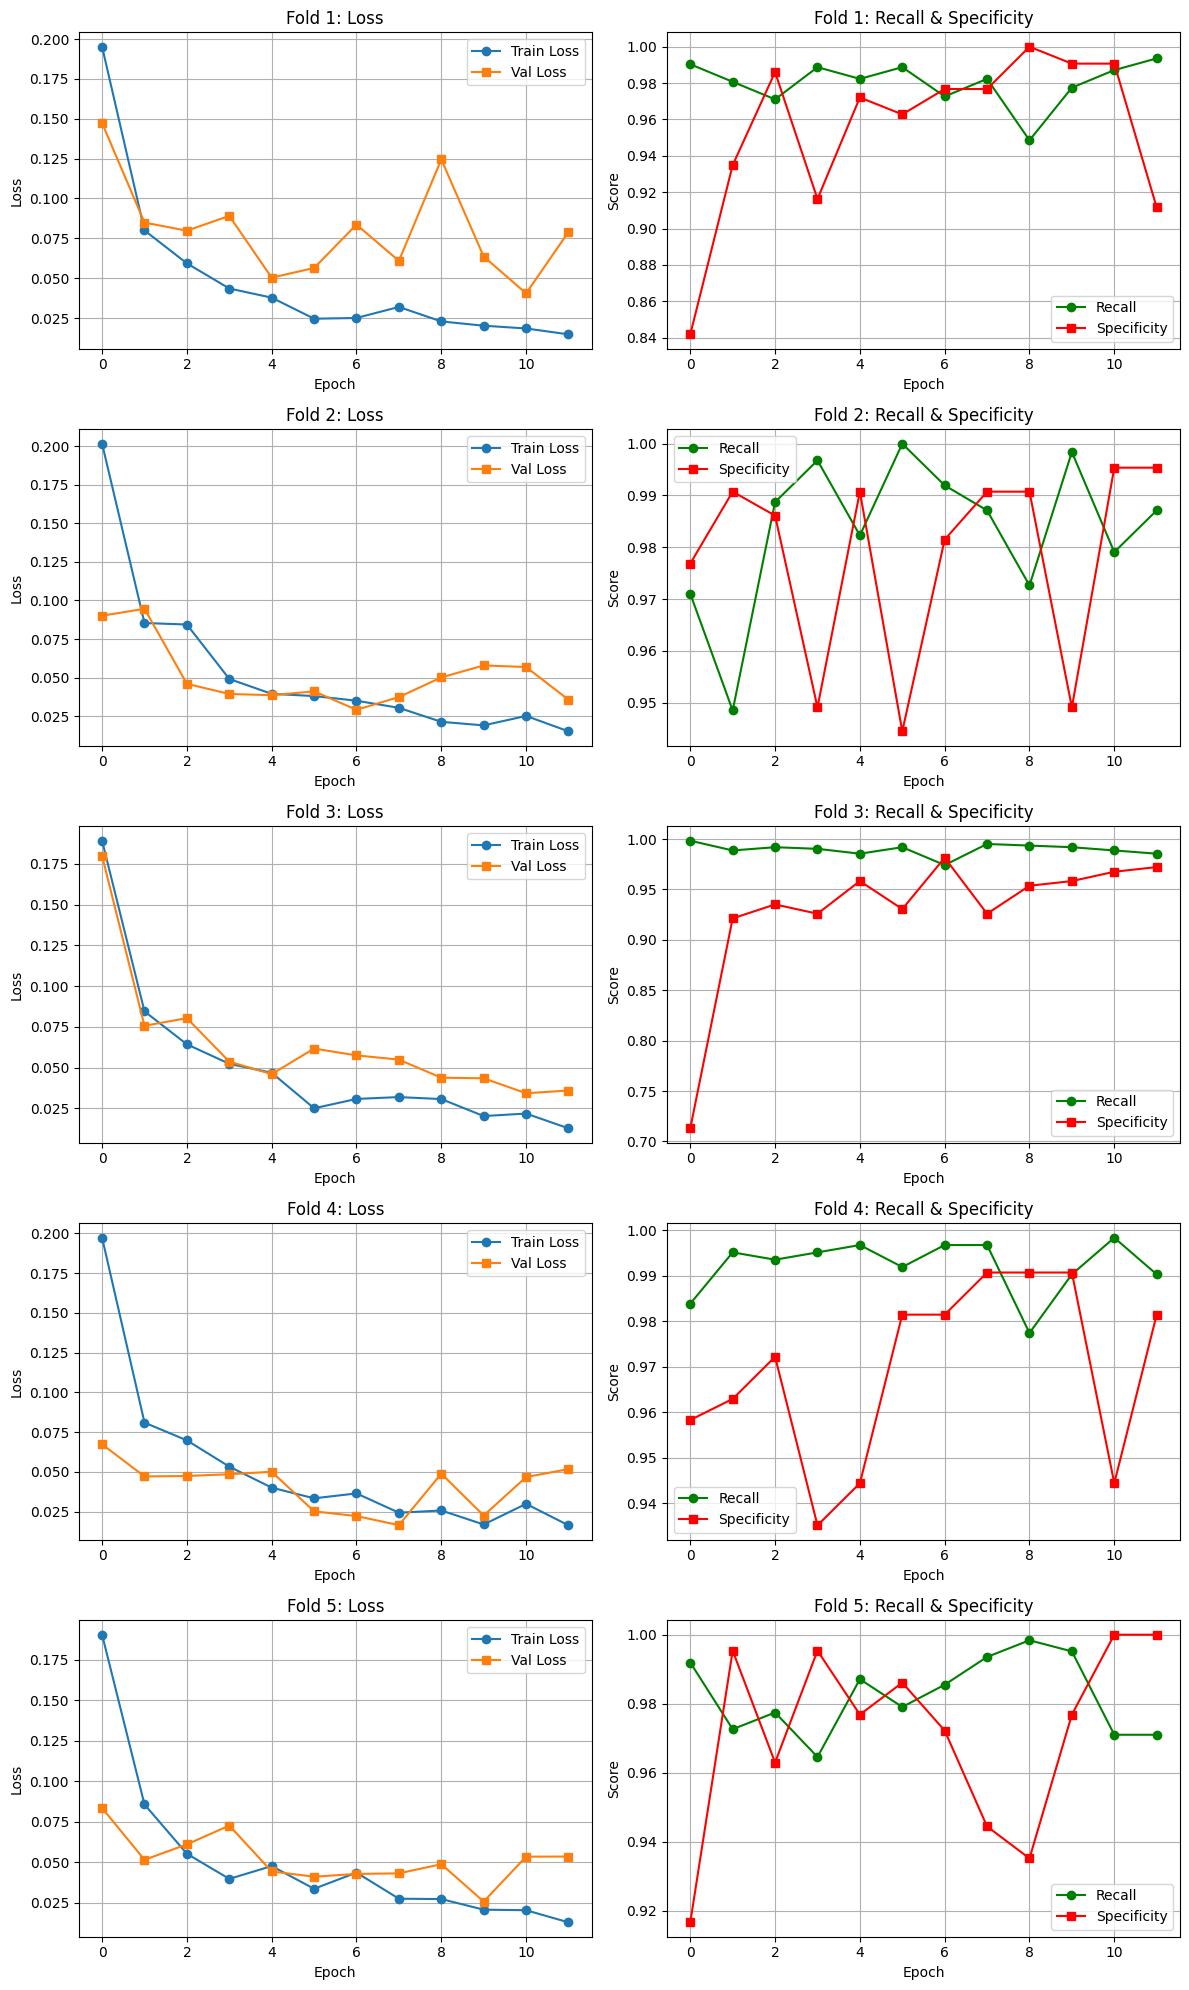

NameError: name 'np' is not defined

In [ ]:
# 5-FOLD LEARNING CROSS VALIDATION
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torchvision import models
from torchvision.models import ResNet50_Weights
import numpy as np

from matplotlib import pyplot as plt

# chose best batch size
best_BC = 32
# using various learning rates
learning_rates = [1e-4, 3e-5]

# CV setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for CV results
fold_data = [[] for _ in range(5)]  # 5 folds
confuse_matrices = [] #[fold] = confusion_matrix

num_epochs = 12

print("\n=== 5-FOLD CV WITH LEARNING CURVES & CONFUSION MATRICES ===\n")
for fold, (train_index, val_index) in enumerate(kf.split(train_df, train_df['label'])):
    print(f"\n--- Fold {fold+1} ---")
    fold_train_df = train_df.iloc[train_index]
    fold_val_df = train_df.iloc[val_index]
        
    # Create dataloaders
    train_dataset = ChestXrayDataset(fold_train_df, transform=train_transform)
    val_dataset = ChestXrayDataset(fold_val_df, transform=val_test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=best_BC, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=best_BC, shuffle=False, num_workers=4)
    
    # Model, criterion, optimizer
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)  # binary classification
    model = model.to(device)
    
    lr = 1e-4  # fixed learning rate for CV
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # set scheduler
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    
    best_val_acc = 0.0
    
    fold_epoch = []
    all_preds, all_trues = [], []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, preds, trues, probs = eval_epoch(model, val_loader, criterion)
        val_recall, val_specificity, val_f1, val_auc = compute_metrics(trues, preds, probs)

        all_preds.extend(preds)
        all_trues.extend(trues)
        
        val_acc = (val_recall + val_specificity) / 2
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, \
              Val Acc: {val_acc:.4f}, Val Recall:{val_recall:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
        
        # save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')

        fold_epoch.append({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_recall': val_recall,
            'val_specificity': val_specificity,
            'val_f1': val_f1,
            'val_auc': val_auc
        })
    fold_data[fold] = fold_epoch
    confuse_matrices.append(confusion_matrix(all_trues, all_preds))

# ======== INDIVIDUAL LEARNING CURVES PER FOLD ========
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
for fold in range(5):
    epochs = [data['epoch'] for data in fold_data[fold]]
    train_loss = [data['train_loss'] for data in fold_data[fold]]
    val_loss = [data['val_loss'] for data in fold_data[fold]]
    recall = [data['val_recall'] for data in fold_data[fold]]
    specificity = [data['val_specificity'] for data in fold_data[fold]]
    
    axes[fold, 0].plot(train_loss, label='Train Loss', marker='o')
    axes[fold, 0].plot(val_loss,   label='Val Loss',   marker='s')
    axes[fold, 0].set_title(f'Fold {fold+1}: Loss')
    axes[fold, 0].set_xlabel('Epoch')
    axes[fold, 0].set_ylabel('Loss')
    axes[fold, 0].legend()
    axes[fold, 0].grid(True)

    axes[fold, 1].plot(recall, label='Recall',      marker='o', color='green')
    axes[fold, 1].plot(specificity,   label='Specificity', marker='s', color='red')
    axes[fold, 1].set_title(f'Fold {fold+1}: Recall & Specificity')
    axes[fold, 1].set_xlabel('Epoch')
    axes[fold, 1].set_ylabel('Score')
    axes[fold, 1].legend()
    axes[fold, 1].grid(True)
plt.tight_layout()
plt.show()




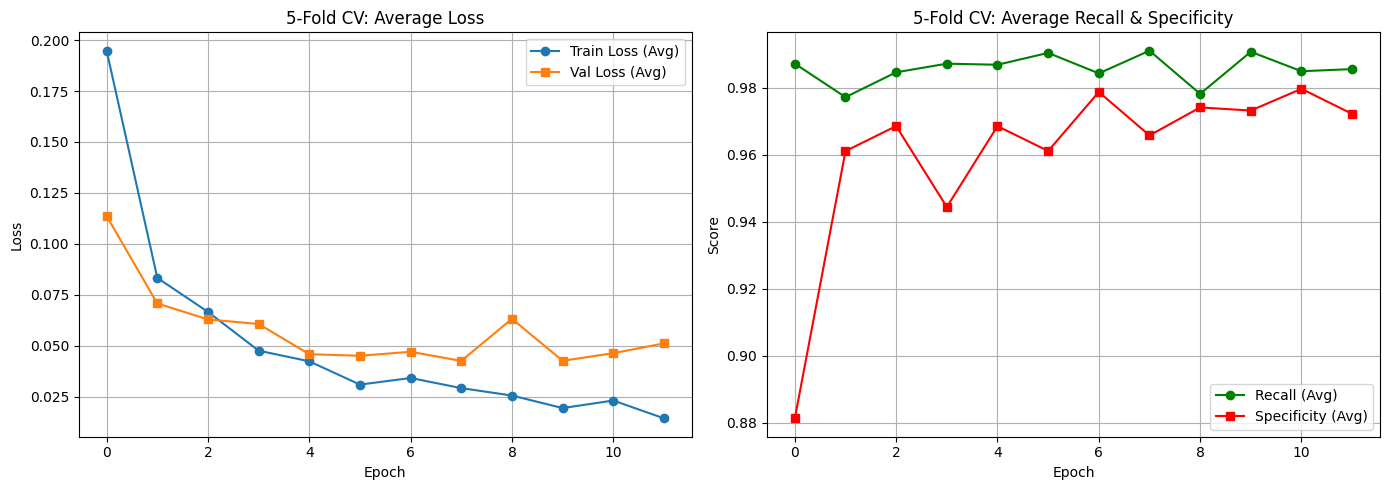

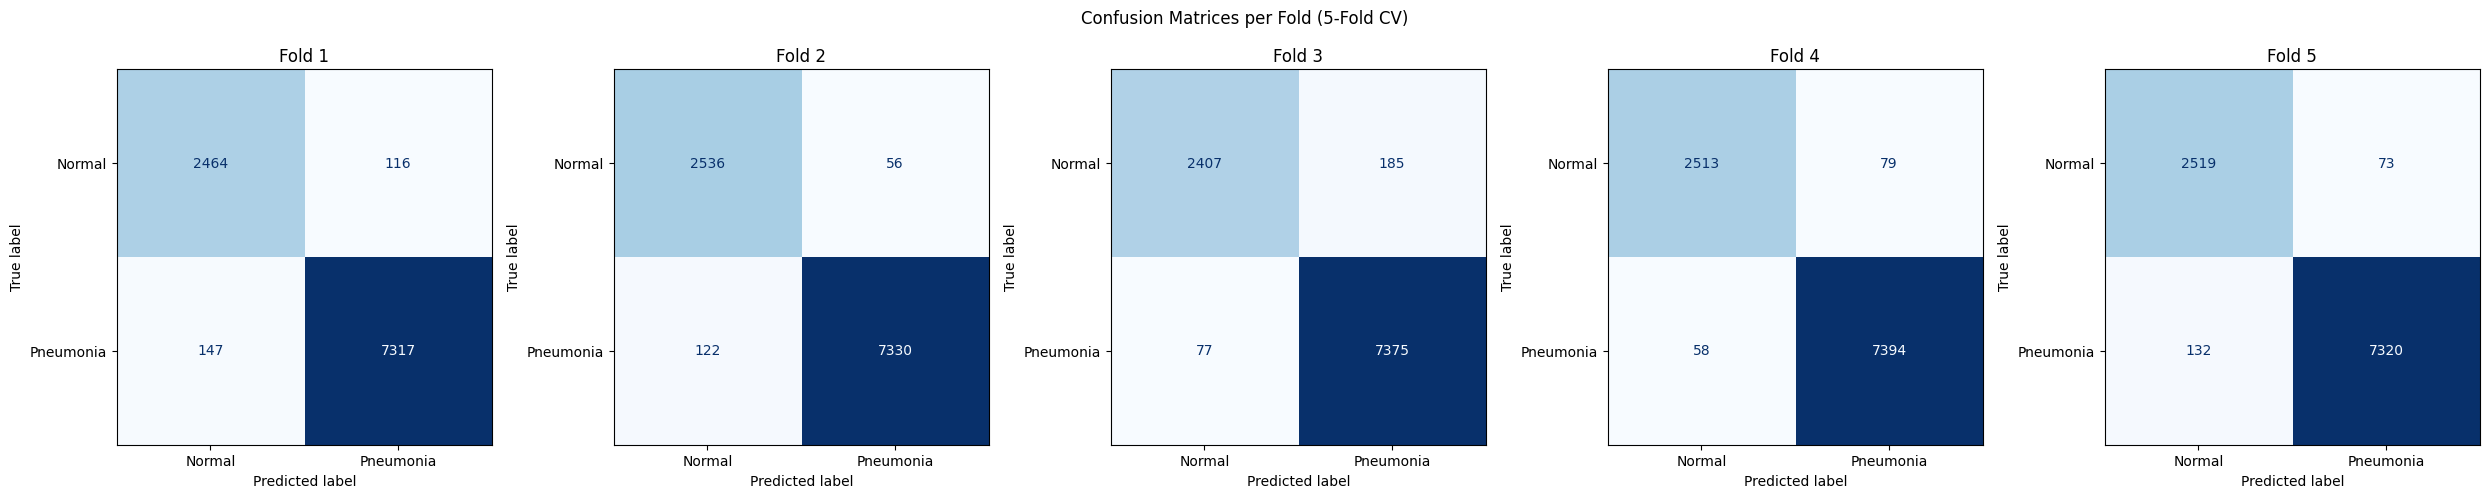


=== 5-FOLD CV FINAL SUMMARY ===
Recall     : 0.9855 ± 0.0078
Specificity: 0.9721 ± 0.0318
F1         : 0.9821 ± 0.0063


In [8]:
import numpy as np
from matplotlib import pyplot as plt
# === AVERAGED LEARNING CURVES ===
avg_train_loss = np.mean([[data['train_loss'] for data in fold_data[fold]] for fold in range(5)], axis=0)
avg_val_loss = np.mean([[data['val_loss'] for data in fold_data[fold]] for fold in range(5)], axis=0)
avg_recall = np.mean([[data['val_recall'] for data in fold_data[fold]] for fold in range(5)], axis=0)
avg_specificity = np.mean([[data['val_specificity'] for data in fold_data[fold]] for fold in range(5)], axis=0)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Train Loss (Avg)', marker='o')
plt.plot(avg_val_loss,   label='Val Loss (Avg)',   marker='s')
plt.title('5-Fold CV: Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avg_recall, label='Recall (Avg)',      marker='o', color='green')
plt.plot(avg_specificity,   label='Specificity (Avg)', marker='s', color='red')
plt.title('5-Fold CV: Average Recall & Specificity')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === CONFUSION MATRICES ===
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, cm in enumerate(confuse_matrices):
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Fold {i+1}')
plt.suptitle('Confusion Matrices per Fold (5-Fold CV)')
plt.tight_layout()
plt.show()

# === FINAL CV SUMMARY ===
# Fix: Access the last epoch's metrics from each fold
final_recalls = [fold_data[i][-1]["val_recall"] for i in range(5)]
final_specs   = [fold_data[i][-1]["val_specificity"] for i in range(5)]
final_f1      = [fold_data[i][-1]["val_f1"] for i in range(5)]

print("\n=== 5-FOLD CV FINAL SUMMARY ===")
print(f"Recall     : {np.mean(final_recalls):.4f} ± {np.std(final_recalls):.4f}")
print(f"Specificity: {np.mean(final_specs):.4f} ± {np.std(final_specs):.4f}")
print(f"F1         : {np.mean(final_f1):.4f} ± {np.std(final_f1):.4f}")

# Train with oversampling

In [39]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# 0. CUSTOM DATASET
# ===============================
class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


# ===============================
# 1. METRICS
# ===============================
def compute_metrics(y_true, y_pred, y_prob):
    recall = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-8)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    return recall, specificity, f1, auc


# ===============================
# 2. TRAIN / EVAL FUNCTIONS
# ===============================
def train_epoch_binary(model, loader, criterion, optimizer, threshold=0.5):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        preds = (torch.sigmoid(outputs) >= threshold).int()
        correct += (preds.cpu() == labels.cpu().int()).sum().item()
        total += labels.size(0)

    return running_loss / len(loader.dataset), correct / total


def eval_epoch_binary(model, loader, criterion, threshold=0.5):
    model.eval()
    running_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy().flatten())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    preds = (all_probs >= threshold).astype(int)

    return running_loss / len(loader.dataset), preds, all_labels, all_probs


# ===============================
# 3. CROSS-VALIDATION PIPELINE
# ===============================
def cross_validate(df, train_transform, val_test_transform, n_splits=5, batch_size=32, lr=1e-4, num_epochs=12, threshold=0.7):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
        print(f"\n===== Fold {fold+1} / {n_splits} =====")

        train_subset = Subset(ChestXrayDataset(df, transform=train_transform), train_idx)
        val_subset   = Subset(ChestXrayDataset(df, transform=val_test_transform), val_idx)

        # Oversampling sampler
        train_labels = df.iloc[train_idx]['label']
        class_counts = train_labels.value_counts().to_dict()
        total = len(train_labels)
        class_weights = {cls: total/cnt for cls, cnt in class_counts.items()}
        sample_weights = [class_weights[l] for l in train_labels]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler, num_workers=4)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

        # Model, criterion, optimizer
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, 1)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        best_balanced = 0
        best_model_path = f"best_model_fold{fold+1}.pth"

        # Training loop
        for epoch in range(num_epochs):
            train_loss, train_acc = train_epoch_binary(model, train_loader, criterion, optimizer, threshold=threshold)
            val_loss, val_preds, val_trues, val_probs = eval_epoch_binary(model, val_loader, criterion, threshold=threshold)

            recall, spec, f1, auc = compute_metrics(val_trues, val_preds, val_probs)
            balanced = (recall + spec) / 2
            acc = accuracy_score(val_trues, val_preds)

            print(f"Epoch {epoch+1}/{num_epochs} | TrainLoss={train_loss:.4f} | TrainAcc={train_acc:.4f}"
                  f" | ValAcc={acc:.4f} | ValRec={recall:.3f} | ValSpec={spec:.3f} | BalAcc={balanced:.3f} | AUC={auc:.3f}")

            if balanced > best_balanced:
                best_balanced = balanced
                torch.save(model.state_dict(), best_model_path)
                print(" --> Saved Best Model")

        # Evaluate fold
        val_loss, val_preds, val_trues, val_probs = eval_epoch_binary(model, val_loader, criterion)
        recall, spec, f1, auc = compute_metrics(val_trues, val_preds, val_probs)
        fold_results.append({
            "fold": fold+1,
            "recall": recall,
            "specificity": spec,
            "f1": f1,
            "auc": auc
        })

    return fold_results

In [15]:
# ===============================
# 4. RUN CROSS-VALIDATION
# ===============================
fold_metrics = cross_validate(train_df, train_transform, val_test_transform, n_splits=5, num_epochs=5, threshold=0.6)
for fm in fold_metrics:
    print(f"Fold {fm['fold']}: Recall={fm['recall']:.3f}, Spec={fm['specificity']:.3f}, F1={fm['f1']:.3f}, AUC={fm['auc']:.3f}")

# compute mean and std of fold metrics
mean_recall = np.mean([fm['recall'] for fm in fold_metrics])
std_recall = np.std([fm['recall'] for fm in fold_metrics])
mean_spec = np.mean([fm['specificity'] for fm in fold_metrics])
std_spec = np.std([fm['specificity'] for fm in fold_metrics])
mean_f1 = np.mean([fm['f1'] for fm in fold_metrics])
std_f1 = np.std([fm['f1'] for fm in fold_metrics])
mean_auc = np.mean([fm['auc'] for fm in fold_metrics])
std_auc = np.std([fm['auc'] for fm in fold_metrics])

print(f"\n=== CROSS-VALIDATION SUMMARY ===")
print(f"Recall     : {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Specificity: {mean_spec:.4f} ± {std_spec:.4f}")
print(f"F1 Score   : {mean_f1:.4f} ± {std_f1:.4f}")
print(f"AUC        : {mean_auc:.4f} ± {std_auc:.4f}")



===== Fold 1 / 5 =====
Epoch 1/5 | TrainLoss=0.2004 | TrainAcc=0.9343 | ValAcc=0.9211 | ValRec=0.899 | ValSpec=0.986 | BalAcc=0.942 | AUC=0.993
 --> Saved Best Model
Epoch 2/5 | TrainLoss=0.0804 | TrainAcc=0.9698 | ValAcc=0.9785 | ValRec=0.979 | ValSpec=0.977 | BalAcc=0.978 | AUC=0.997
 --> Saved Best Model
Epoch 3/5 | TrainLoss=0.0526 | TrainAcc=0.9815 | ValAcc=0.9809 | ValRec=0.976 | ValSpec=0.995 | BalAcc=0.986 | AUC=0.998
 --> Saved Best Model
Epoch 4/5 | TrainLoss=0.0425 | TrainAcc=0.9854 | ValAcc=0.9701 | ValRec=0.989 | ValSpec=0.916 | BalAcc=0.953 | AUC=0.996
Epoch 5/5 | TrainLoss=0.0386 | TrainAcc=0.9878 | ValAcc=0.9785 | ValRec=0.977 | ValSpec=0.981 | BalAcc=0.979 | AUC=0.997

===== Fold 2 / 5 =====
Epoch 1/5 | TrainLoss=0.2282 | TrainAcc=0.9179 | ValAcc=0.9558 | ValRec=0.944 | ValSpec=0.991 | BalAcc=0.967 | AUC=0.998
 --> Saved Best Model
Epoch 2/5 | TrainLoss=0.0720 | TrainAcc=0.9737 | ValAcc=0.9331 | ValRec=0.910 | ValSpec=1.000 | BalAcc=0.955 | AUC=0.998
Epoch 3/5 | Train

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        
        # --- Block 1 ---
        # Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(150,150,1))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # MaxPool2D((2,2), strides=2, padding='same')
        # ceil_mode=True is used to mimic Keras padding='same' behavior on odd dimensions
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        # --- Block 2 ---
        # Conv2D(64, (3,3), strides=1, padding='same', activation='relu')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        # --- Block 3 ---
        # Conv2D(64, (3,3), strides=1, padding='same', activation='relu')
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        # --- Block 4 ---
        # Conv2D(128, (3,3), strides=1, padding='same', activation='relu')
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(0.2)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        # --- Block 5 ---
        # Conv2D(256, (3,3), strides=1, padding='same', activation='relu')
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.dropout3 = nn.Dropout(0.2)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        # --- Classifier ---
        # Calculation for flattened size:
        # Input: 150 -> 75 -> 38 -> 19 -> 10 -> 5
        # Final Feature Map: 256 channels x 5 x 5
        self.fc1 = nn.Linear(256 * 5 * 5, 128)
        self.dropout4 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        x = self.bn2(x)
        x = self.pool2(x)

        # Block 3
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool3(x)
        
        # Block 4
        x = F.relu(self.conv4(x))
        x = self.dropout2(x)
        x = self.bn4(x)
        x = self.pool4(x)
        
        # Block 5
        x = F.relu(self.conv5(x))
        x = self.dropout3(x)
        x = self.bn5(x)
        x = self.pool5(x)

        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dense Layers
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        # x = torch.sigmoid(self.fc2(x)) # Sigmoid activation as requested
        
        return x

# Instantiate the model
model = BinaryClassifier()

# Verify the output shape matches expected architecture
dummy_input = torch.randn(1, 1, 150, 150) # Batch size 1, 1 Channel, 150x150
output = model(dummy_input)
print(f"Output shape: {output.shape}") # Should be [1, 1]

Output shape: torch.Size([1, 1])


In [ ]:
# sechedule learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms


# ===============================
# 5. Train FINAL MODEL ON FULL TRAINING SET & EVALUATE ON TEST SET
# ===============================
# Using best hyperparameters from CV
best_lr = 1e-4
best_BC = 32
threshold = 0.5

# define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # convert to grayscale
    # transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    # Normalize with ImageNet stats, beacause resnet is pretrained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataloaders
train_dataset = ChestXrayDataset(train_df, transform=train_transform)
val_dataset = ChestXrayDataset(val_df, transform=val_test_transform)
test_dataset = ChestXrayDataset(test_df, transform=val_test_transform)

# Oversampling sampler
train_labels = train_df['label']
class_counts = train_labels.value_counts().to_dict()
total = len(train_labels)
class_weights = {cls: total/cnt for cls, cnt in class_counts.items()}
sample_weights = [class_weights[l] for l in train_labels]
# sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=best_BC, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=best_BC, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=best_BC, shuffle=False, num_workers=4)

# Model, criterion, optimizer
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = torch.nn.Linear(model.fc.in_features, 1)  # binary classification
model = model.to(device)
# model = BinaryClassifier()
# model = model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 12
best_balanced = 0.0
best_path = "best_custom_model.pth"

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_binary(model, train_loader, criterion, optimizer, threshold=threshold)
    val_loss, val_preds, val_trues, val_probs = eval_epoch_binary(model, val_loader, criterion, threshold=threshold)

    scheduler.step(val_loss)

    recall, spec, f1, auc = compute_metrics(val_trues, val_preds, val_probs)
    balanced = (recall + spec) / 2
    acc = accuracy_score(val_trues, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs} | TrainLoss={train_loss:.4f} | TrainAcc={train_acc:.4f}"
          f" | ValAcc={acc:.4f} | ValRec={recall:.3f} | ValSpec={spec:.3f} | BalAcc={balanced:.3f} | AUC={auc:.3f}")

    if balanced > best_balanced:
        best_balanced = balanced
        torch.save(model.state_dict(), best_path)
        print(" --> Saved Best Model")

model.load_state_dict(torch.load(best_path))
model.to(device)

test_loss, test_preds, test_trues, test_probs = eval_epoch_binary(model, test_loader, criterion)
recall, spec, f1, auc = compute_metrics(test_trues, test_preds, test_probs)

print("\n=== FINAL TEST METRICS ===")
print(f"Recall     : {recall:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"AUC        : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(test_trues, test_preds, target_names=["Normal", "Pneumonia"]))

/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/12 | TrainLoss=0.2148 | TrainAcc=0.9013 | ValAcc=0.9637 | ValRec=0.964 | ValSpec=0.963 | BalAcc=0.963 | AUC=0.995
 --> Saved Best Model
Epoch 2/12 | TrainLoss=0.1042 | TrainAcc=0.9587 | ValAcc=0.9723 | ValRec=0.972 | ValSpec=0.974 | BalAcc=0.973 | AUC=0.996
 --> Saved Best Model
Epoch 3/12 | TrainLoss=0.0847 | TrainAcc=0.9680 | ValAcc=0.9838 | ValRec=0.991 | ValSpec=0.963 | BalAcc=0.977 | AUC=0.998
 --> Saved Best Model
Epoch 4/12 | TrainLoss=0.0735 | TrainAcc=0.9723 | ValAcc=0.9618 | ValRec=0.950 | ValSpec=0.996 | BalAcc=0.973 | AUC=0.999
Epoch 5/12 | TrainLoss=0.0719 | TrainAcc=0.9728 | ValAcc=0.9427 | ValRec=0.927 | ValSpec=0.989 | BalAcc=0.958 | AUC=0.997
Epoch 6/12 | TrainLoss=0.0681 | TrainAcc=0.9759 | ValAcc=0.9694 | ValRec=0.967 | ValSpec=0.978 | BalAcc=0.972 | AUC=0.997
Epoch 7/12 | TrainLoss=0.0484 | TrainAcc=0.9821 | ValAcc=0.9847 | ValRec=0.988 | ValSpec=0.974 | BalAcc=0.981 | AUC=0.998
 --> Saved Best Model
Epoch 8/12 | TrainLoss=0.0514 | TrainAcc=0.9797 | ValAcc=0